<a href="https://colab.research.google.com/github/Thanos002/Anwendungen_KI/blob/main/BerTweet_Bonus_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KIT Angewandte Informatik: Anwendungen der KI Bonus 2024

This code implements a sentiment analysis model to classify Twitter comments into three categories: 'hate', 'offensive', and 'neither'. The classification is performed using a BERTweet model, a variant of the well-known BERT model specifically fine-tuned for analyzing tweets. The model is designed to understand the nuances and context of the language used in Twitter, which makes it particularly suitable for this task.

This code utilizes BERTweet, the first public large-scale language model specifically pre-trained on a corpus of 850M English Tweets. BERTweet adopts the RoBERTa pre-training procedure with a configuration akin to BERT-base. Its training corpus, ensures a rich understanding of the linguistic nuances in tweets. Demonstrating superiority over models like RoBERTa-base and XLM-R-base, BERTweet sets new benchmarks in performance for Tweet NLP tasks, including Part-of-speech tagging, Named-entity recognition, and text classification. The model's specialized training and proven efficacy make it an ideal choice for the sentiment analysis task in this code, aiming to categorize Twitter comments accurately into 'hate', 'offensive', and 'neither' categories.

The process begins with the installation and import of necessary libraries and modules, particularly from the Hugging Face's Transformers library which provides the pre-trained BERTweet model. The model and its tokenizer are then loaded with pre-trained weights.

The dataset is prepared and pre-processed to be compatible with the model. It involves cleaning the tweets, handling HTML entities, removing unnecessary characters, and converting the text into a suitable format for the model (tokenization). The maximum token length is determined based on the dataset to ensure efficient processing.

The dataset is split into training, validation, and test sets. PyTorch's DataLoader is utilized to efficiently load the data in batches during the training and evaluation phases.

The SentimentClassifier class is defined to be a wrapper around the BERTweet model. It includes a dropout layer for regularization and a linear layer for classification. The model is trained over several epochs, and its performance is evaluated on the validation set after each epoch. Early stopping is employed to halt the training if the validation accuracy does not improve for a consecutive number of epochs, preventing overfitting.

After training, the model with the best performance on the validation set is saved and then used to make predictions on the test set. The results are stored in a new DataFrame, which is then saved to a CSV file.

Finally, the model's performance is assessed using a confusion matrix and a classification report, providing insights into its precision, recall, and F1-score for each class.

Copyright (c) 2024 Thanos Drossos

#### Model Definition


Install necessary libraries and dependencies

In [1]:

"""
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip3 install --upgrade .
"""

'\n!git clone https://github.com/huggingface/transformers.git\n%cd transformers/\n!pip3 install --upgrade .\n'

In [2]:
!pip3 install emoji
!pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00


Log file (if needed)

In [3]:
def writeResultsInFile(accuracy, f1_score, random_seed):
    f = open("log", "a")
    f.write(f'Random seed : {random_seed}, accuracy : {accuracy}, f1-score : {f1_score}')
    f.close()


Initialize the BERTweet pre-trained model (vinai/bertweet-base). The BERTweet model was proposed in [BERTweet: A pre-trained language model for English Tweets ](https://www.aclweb.org/anthology/2020.emnlp-demos.2.pdf) by Dat Quoc Nguyen, Thanh Vu, Anh Tuan Nguyen. Since it has been trained on a large twitter corpus using the RoBERTa pre-training procedure and outperforms other state of the art models, I consider it suitable for the proposed Twitter NLP classification task

In [4]:
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Import further necessary libraries

In [36]:
import transformers
import torch
import html
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

Create general Tweet Dataset class and further functions for data loaders

In [6]:
class SATweetDataset(Dataset):
  """
  Custom dataset class for tweet sentiment analysis.

  Args:
    tweets (list): List of tweets.
    tokenizer (object): Tokenizer object for encoding the tweets.
    max_len (int): Maximum length of the encoded tweets.
    targets (list, optional): List of target labels for the tweets. Defaults to None.

  Returns:
    dict: Dictionary containing the tweet text, input IDs, attention mask, and targets (if available).
  """
  def __init__(self, tweets, tokenizer, max_len, targets=None):
    self.tweets = tweets
    self.targets = targets if targets is not None else []
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    target = None
    tweet = str(self.tweets[item])
    if self.targets is not None and item < len(self.targets):
      target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    item_dict = {
        'tweet_text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten()
    }

    # Include 'targets' in the dictionary only if they are available
    if target is not None:
        item_dict['targets'] = torch.tensor(self.targets[item], dtype=torch.long)

    return item_dict

In [7]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """
    Create a data loader for the given dataframe using the specified tokenizer and parameters.

    Args:
        df (pandas.DataFrame): The dataframe containing the tweets and targets.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the tweets.
        max_len (int): The maximum length of the tokenized sequences.
        batch_size (int): The batch size for the data loader.

    Returns:
        torch.utils.data.DataLoader: The data loader for the given dataframe.
    """

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [8]:
def create_test_data_loader(df, tokenizer, max_len, batch_size):

  # Same as above, but is only to be used for unlabeled data (no targets column)

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [9]:
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

Sentiment Classifier

In [10]:
class SentimentClassifier(nn.Module):
  """
  A sentiment classifier based on BERTweet model.

  Args:
    n_classes (int): The number of sentiment classes.

  Attributes:
    bert (BertModel): The BERTweet model.
    out (Linear): The output layer for classification.

  """
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bertweet.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.drop = nn.Dropout(p = 0.33)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    """
    Perform forward pass of the sentiment classifier.

    Args:
      input_ids (torch.Tensor): The input token IDs.
      attention_mask (torch.Tensor): The attention mask.

    Returns:
      torch.Tensor: The output logits.

    """
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    #output = self.drop(pooled_output)
    output = pooled_output
    return self.out(output)

Functions for training and evaluation

In [11]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
 """
  Trains the model for one epoch.

  Args:
    model (torch.nn.Module): The model to be trained.
    data_loader (torch.utils.data.DataLoader): The data loader for training data.
    loss_fn (torch.nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    device (torch.device): The device to be used for training.
    n_examples (int): The total number of training examples.

  Returns:
    Tuple[float, float]: A tuple containing the accuracy and average loss for the epoch.
  """
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [12]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  """
  Evaluate the performance of a model on a given data loader.

  Args:
    model (torch.nn.Module): The model to evaluate.
    data_loader (torch.utils.data.DataLoader): The data loader containing the evaluation data.
    loss_fn: The loss function used for evaluation.
    device (torch.device): The device to perform the evaluation on.
    n_examples (int): The total number of examples in the evaluation data.

  Returns:
    Tuple[float, float]: A tuple containing the accuracy and average loss of the model on the evaluation data.
  """
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def get_predictions(model, data_loader):
  """
  Generates predictions using the provided model and data loader.

  Args:
    model (torch.nn.Module): The trained model to use for predictions.
    data_loader (torch.utils.data.DataLoader): The data loader containing the input data.

  Returns:
    tuple: A tuple containing the following:
      - tweets_content (list): A list of the tweet texts.
      - predictions (torch.Tensor): A tensor containing the predicted labels.
      - prediction_probs (torch.Tensor): A tensor containing the predicted probabilities.
      - real_values (torch.Tensor, optional): A tensor containing the actual labels, if available.
  """
  model = model.eval()

  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
# Check if targets are available in the batch
      if 'targets' in d is not None:
        targets = d["targets"].to(device)
        real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  if real_values:
    real_values = torch.stack(real_values).cpu()
    return tweets_content, predictions, prediction_probs, real_values
  else:
    return tweets_content, predictions, prediction_probs

In [14]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [15]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)


In [16]:
def f1_np(y_test, y_pred):
    f1_n, _,f1_p = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)



####Bonus 2024

Moung GOogle drive to access dataset

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Pre Pre-procesing: create dataframjes from CSV, unescape HTML and (if needed) remove token "RT " (keeping it yields better results for now!)

In [37]:
# Load training and testing datasets (assuming they are saved in Google drive)
df_Bonus_train = pd.read_csv('/content/drive/My Drive/train.csv', names = ['id', 'body', 'target'], header=0)
df_Bonus_test = pd.read_csv('/content/drive/My Drive/test_no_label.csv', names = ['id', 'body', 'target'], header=0)
# Unescape HTML entities to display emojis
df_Bonus_train['body'] = df_Bonus_train['body'].apply(html.unescape)
df_Bonus_test['body'] = df_Bonus_test['body'].apply(html.unescape)
#df_Bonus_train['body'] = df_Bonus_train['body'].str.replace("RT ", "", regex=False)
#df_Bonus_test['body'] = df_Bonus_test['body'].str.replace("RT ", "", regex=False)
df_Bonus_train

,id,body,target
0,0,#anywere “@TheCooleyShow: LA = palm trees and ...,1
1,1,@OfficialA1King: The face you make when you se...,1
2,2,bitch get off my twitter hoe 👊,1
3,3,I can taste loud n pussy on my tongue 😝,1
4,4,Diabetes galore 😂😂😂😂😂 @TIME: Colorado health o...,2
...,...,...,...
19821,19821,"@_BredDIFFERENT: Niggas will fuck yah good , e...",1
19822,19822,Soft niggas usually send the hate threw the bi...,1
19823,19823,@_POCAPetite: stick by his side and don't give...,1
19824,19824,@Blakeanthony98: “@Thompson_Era: “@hiagokoury:...,1


In [40]:
# set target column to int
df_Bonus_train['target'] = df_Bonus_train['target'].astype(int)

Calculate token lengths for each text in the given dataframe:

In [42]:
token_lens = []
for txt in df_Bonus_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Plot a histogram of token lengths:

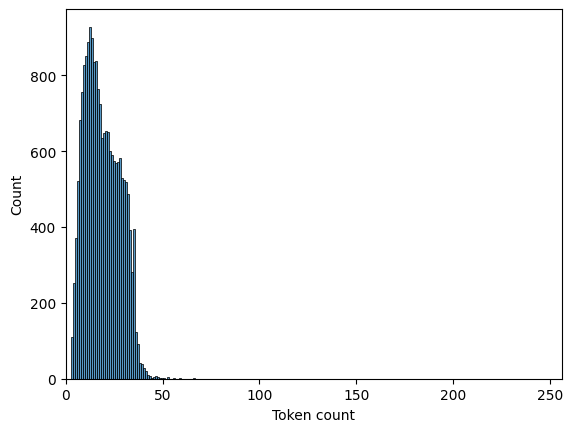

In [43]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [44]:
MAX_LEN = max(token_lens)
BATCH_SIZE = 32

In [45]:
MAX_LEN

67

Split the dataset into training, validation and test set

In [46]:
RANDOM_SEED = 1993
df_train, df_val = train_test_split(df_Bonus_train, test_size=0.1, random_state=RANDOM_SEED)
df_test = df_Bonus_test

Create data loaders:

In [48]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_test_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Fetch the first batch of data from the data loader:

In [49]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [50]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

Set class number and names:

In [51]:
n_classes = 3
class_names = ['hate', 'offensive', 'neither']

Move input data to cuda and check batch sizes

In [52]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 67])
torch.Size([32, 67])


Intitialize model and send it to cuda

In [53]:
model = SentimentClassifier(n_classes)
model = model.to(device)

Initialize the necessary components for training a BERTweet model.
Set the number of training epochs, define the optimizer with a learning rate of 1e-5,
calculate the total number of training steps, create a scheduler with a linear decay in the learning rate,
and define the loss function as CrossEntropyLoss.

In [54]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Traing loop for the model, saving a training history and keeping track of the best model state. Stops early if validation accuracy does not improve over 5 consecutive epochs to prevent overfitting.

In [55]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bertweet_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.3466081965087135 accuracy 0.8856134058174074
Val   loss 0.2177740489883769 accuracy 0.9263741805345437

Epoch 2/30
----------
Train loss 0.22071231973414246 accuracy 0.9234994115339349
Val   loss 0.198750049476662 accuracy 0.9253656076651539

Epoch 3/30
----------
Train loss 0.18880525507753895 accuracy 0.9343159782547779
Val   loss 0.20558259191532288 accuracy 0.9223398890569845

Epoch 4/30
----------
Train loss 0.15961432772918896 accuracy 0.9447402342655383
Val   loss 0.24386055767536163 accuracy 0.9172970247100354

Epoch 5/30
----------
Train loss 0.13105342980460882 accuracy 0.9539315137588971
Val   loss 0.25970727325447146 accuracy 0.9127584467977812

Epoch 6/30
----------
Train loss 0.10318338510990945 accuracy 0.9627865269293281
Val   loss 0.28457387464661754 accuracy 0.9127584467977812

CPU times: user 19min 18s, sys: 5.95 s, total: 19min 24s
Wall time: 20min 56s


Load the state of the model with the best validation:

In [56]:
model.load_state_dict(torch.load('bertweet_best_model_state.bin'))

<All keys matched successfully>

Set model to evaluation mode and get model predictions

In [58]:
model.eval()
y_tweet_texts, y_pred, y_pred_probs = get_predictions(
  model,
  test_data_loader
)


Save predictions to csv file

In [59]:
y_pred_list = y_pred.tolist()
assert len(y_pred_list) == len(df_test), "Length of predictions does not match the number of tweets in the DataFrame."
df_test['Prediction'] = y_pred_list
df_test.to_csv('/content/drive/My Drive/test_labeled.csv', index=False)


Classification report on validation set

In [60]:
# Get predictions for the validation set
_, val_predictions, _, val_labels = get_predictions(model, val_data_loader)

# Generate classification report
report = classification_report(val_labels, val_predictions)
print(report)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

           0       0.53      0.32      0.40       104
           1       0.94      0.98      0.96      1539
           2       0.93      0.89      0.91       340

    accuracy                           0.93      1983
   macro avg       0.80      0.73      0.75      1983
weighted avg       0.92      0.93      0.92      1983



Confusion Matrix

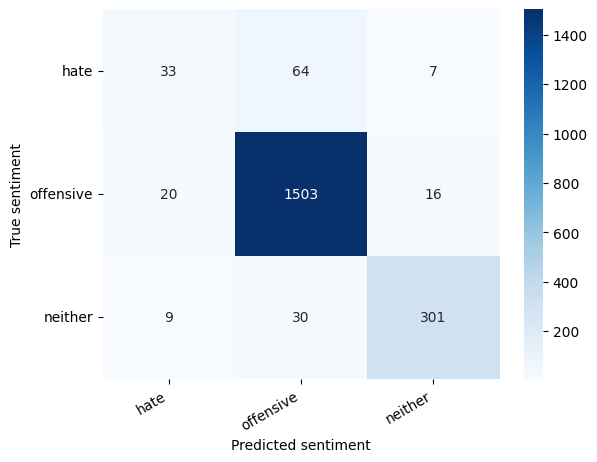

In [61]:
cm = confusion_matrix(val_labels, val_predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)